In [1]:
import pandas as pd
from utilities_DL import get_DataSet_and_invalid_dates,get_MultiModel_loss_args_emb_opts
from DL_class import MultiModelTrainer
from config import get_args
from plotting import plot_k_fold_split
from save_results import build_results_df
from paths import folder_path,file_name,get_save_directory

# Get Parameters : 

In [2]:
# Load config
model_name = 'STGCN' #'CNN' 
args = get_args(model_name)
#args = get_args(model_name = model_name,learn_graph_structure = True)  # MTGNN

# Modification : 
args.epochs = 20
args.K_fold = 2

# Save Directory:
main_dir = get_save_directory(args)

## Define fixed Dataset K_fold split for each trial: 

coverage period: 2019-01-01 00:00:00 - 2020-01-01 00:00:00
Time-step per hour: 4.0


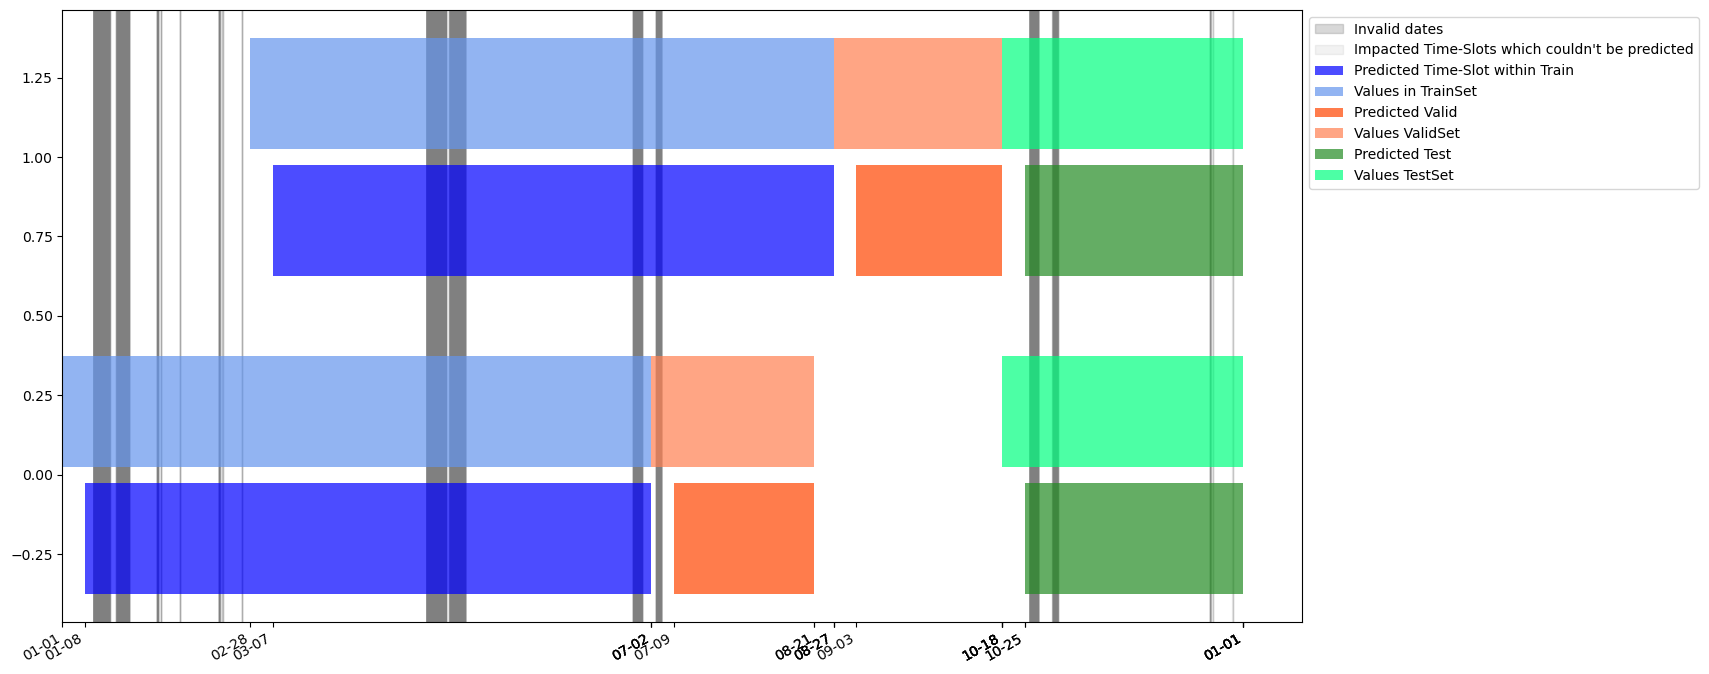

In [3]:
# Load dataset and invalid_dates
dataset,invalid_dates = get_DataSet_and_invalid_dates(folder_path,file_name,args.W,args.D,args.H,args.step_ahead,single_station = False)

# Train / Valid / Test split and Normalize for K-fold 
(Datasets,DataLoader_list,time_slots_labels_list,dic_class2rpz,dic_rpz2class,nb_words_embedding) =  dataset.split_K_fold(args,invalid_dates)

# Plot information about split and folds:
plot_k_fold_split(Datasets,invalid_dates)

# Test complet sur les 3 Top STGCN, avec sauvegarde du model :

In [3]:
results_df = pd.DataFrame()

#for i,(calendar_class,position,specific_lr, type_calendar) in enumerate(zip([3,1,3],['input','input','input'],[True,True,False],['tuple','tuple','tuple'])):
for i,(calendar_class,position,specific_lr, type_calendar) in enumerate(zip([3],['input'],[True],['tuple'])):

    args.calendar_class = calendar_class
    args.position = position
    args.specific_lr = specific_lr
    args.type_calendar = type_calendar

    save_dir = get_save_directory(args)

    # Load dataset and invalid_dates 
    dataset,invalid_dates = get_DataSet_and_invalid_dates(folder_path,file_name,args.W,args.D,args.H,args.step_ahead,single_station = False)
    (Datasets,DataLoader_list,time_slots_labels,dic_class2rpz,dic_rpz2class,nb_words_embedding) =  dataset.split_K_fold(args,invalid_dates)
    
    # Load associated K_folds Models: 
    (loss_function,Model_list,Optimizer_list,args_embedding) = get_MultiModel_loss_args_emb_opts(args,nb_words_embedding,dic_class2rpz)
    multimodeltrainer = MultiModelTrainer(Datasets,Model_list,DataLoader_list,args,Optimizer_list,loss_function,scheduler = None,args_embedding=args_embedding,ray= False,save_dir = save_dir,dic_class2rpz=dic_class2rpz)
    (results_by_fold,mean_picp,mean_mpiw,dict_last_from_mean_of_folds,dict_best_from_mean_of_folds) = multimodeltrainer.K_fold_validation(mod_plot = 1)
    results_by_fold.to_csv(f"{save_dir}results_by_fold.csv")
    
    # Svae results 
    results_df = build_results_df(results_df,args, mean_picp,mean_mpiw,dict_last_from_mean_of_folds,dict_best_from_mean_of_folds)
                            
results_df.to_csv('save_results.csv')
results_df

""
